<a href="https://colab.research.google.com/github/UdaraChamidu/LangGraph/blob/main/Retriever_AI_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install langchain==0.3.24 -q
!pip install langchain-openai -q
!pip install langchain_chroma -q
!pip install langchain_community -q
!pip install langgraph -q
!pip install pypdf -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.3.24 requires langchain<1.0.0,>=0.3.25, but you have langchain 0.3.24 which is incompatible.


In [33]:
import os
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool

In [34]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [35]:
llm = ChatOpenAI(
    model="gpt-3.5-turbo", temperature = 0)

In [36]:
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
)

In [37]:
pdf_loader = PyPDFLoader("/content/Eye Disease Classification Using DL.pdf")

In [38]:
pages = pdf_loader.load()

In [39]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=150,
    chunk_overlap=25
)

In [40]:
pages_split = text_splitter.split_documents(pages)

In [41]:
len(pages_split)

174

In [42]:
vectorstore = Chroma.from_documents(
    documents=pages_split,
    embedding=embeddings,
    persist_directory="./vectorstore",
    collection_name="data"
)

In [43]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3}
)

In [44]:
@tool
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns the information about codepro lk.
    """
    docs = retriever.invoke(query)
    if not docs:
        return "I found no relevant information"
    results = []
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}:\n{doc.page_content}")

    return "\n\n".join(results)

In [45]:
tools = [retriever_tool]

# bind tools to llm
llm_with_tools = llm.bind_tools(tools)

In [46]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [47]:
def should_continue(state: AgentState):
    """Check if the last message contains tool calls."""
    result = state['messages'][-1]
    return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

In [48]:
system_prompt = """
You are an intelligent AI assistant who answers questions about deep learning based on the PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the given data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""

In [49]:
tools_dict = {our_tool.name: our_tool for our_tool in tools}

In [50]:
# LLM Agent

def call_llm(state: AgentState) -> AgentState:
    """Function to call the LLM with the current state."""
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm_with_tools.invoke(messages)
    print(message)
    return {'messages': [message]}

In [51]:
# Retriever Agent

def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""

    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")

        if not t['name'] in tools_dict: # Checks if a valid tool is present
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."

        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")


        # Appends the Tool Message
        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}

In [52]:
workflow = StateGraph(AgentState)

workflow.add_node("llm", call_llm)
workflow.add_node("retriever_agent", take_action)

workflow.add_edge(START, "llm")
workflow.add_conditional_edges(
    "llm",
    should_continue,
    {True: "retriever_agent", False: END}
)
workflow.add_edge("retriever_agent", "llm")

app = workflow.compile()

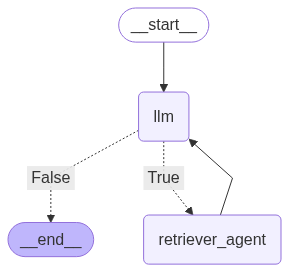

In [53]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [54]:
result = app.invoke({"messages": [HumanMessage(content="what is deep learning")]})

content='' additional_kwargs={'tool_calls': [{'id': 'call_uUb3cwEJQNun6A7nAS9fYDsU', 'function': {'arguments': '{"query":"deep learning"}', 'name': 'retriever_tool'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 138, 'total_tokens': 155, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BfNCRWCEczJpmO8ROsKVUh1BQlcl6', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--67edb630-3181-4d95-a417-c9bc84805d68-0' tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'deep learning'}, 'id': 'call_uUb3cwEJQNun6A7nAS9fYDsU', 'type': 'tool_call'}] usage_metadata={'input_tokens': 138, 'output_tokens': 17, 'total_tokens': 155, 'input_token_details': {'audio': 

In [55]:
result['messages'][-1].content

"Deep learning is a type of machine learning that involves algorithms inspired by the structure and function of the brain's neural networks. It is particularly effective for processing data that is unstructured or unlabeled. In the context of image processing, deep learning can be used for tasks like detecting and diagnosing diseases."

In [57]:
result = app.invoke({"messages": [HumanMessage(content="what is an evaluation matric ?")]})

content='' additional_kwargs={'tool_calls': [{'id': 'call_pUI4U1PNy0D9V7A8xwXcK9Ag', 'function': {'arguments': '{"query":"evaluation metric"}', 'name': 'retriever_tool'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 141, 'total_tokens': 158, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BfNDTI2y9aYtQRG0XosZkUWKwJQEy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--6ecd5987-69d3-4523-8656-03b5e23d84ff-0' tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'evaluation metric'}, 'id': 'call_pUI4U1PNy0D9V7A8xwXcK9Ag', 'type': 'tool_call'}] usage_metadata={'input_tokens': 141, 'output_tokens': 17, 'total_tokens': 158, 'input_token_details': {'